In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib widget # not sure what this does...not in my env
from scipy import signal
import os
from tqdm import trange # for progress bars in loops
from skimage.color import rgb2hsv, rgb2gray
from skimage.filters import threshold_otsu

In [2]:
def array2list(a):
    if a.__class__ is np.ndarray:
        list(a)
    return a
    
def list2array(a):
    if a.__class__ is list:
        np.array(a)
    return a

def zeroD_2_oneD_array(a):
    if np.ndim(a) == 0:
        a = np.array(a)[np.newaxis]
    return a

def resize_text(ax, fntsz=8):
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fntsz)
    for item in ([ax.title]):
        item.set_fontsize(fntsz)

def find_bar_only(img, Shoreline_Index=150):
    from skimage.color import rgb2hsv, rgb2gray
    import numpy as np
    import pandas as pd
    from scipy import signal
    import copy
    gray = np.array(rgb2gray(img), dtype=float)
    BAR_STATS = pd.DataFrame({'Row' : pd.Series([], dtype=int),
                    'BAR_N' : pd.Series([], dtype=int),
                    'Crest_IX' : pd.Series([], dtype=int)}) 
    
    #for px in trange(np.size(gray,axis=0)):
    for px in range(np.size(gray,axis=0)):
        
        if np.size(Shoreline_Index)>1: #Check if Shoreline is scalar or vector
            SL_IX = Shoreline_Index[px]
        else:
            SL_IX = copy.deepcopy(Shoreline_Index)
            
        DF = pd.DataFrame({'D': pd.Series(np.linspace(0, np.shape(img)[1], np.shape(img)[1]+1), dtype=float),
                        'Z_gray': pd.Series(gray[px,::]/np.nanmax(gray[px,::]), dtype=float)})

        wndl = 5
        DF['Zs_gray'] = np.concatenate((np.repeat(np.nan, np.floor(wndl/2).astype(int)),
                                         np.convolve(np.repeat(1,wndl).astype(float), DF.Z_gray, 'valid')/wndl, 
                                         np.repeat(np.nan, np.floor(wndl/2).astype(int))))
        DF['Zs_gray'] = DF['Zs_gray'].fillna(DF.Z_gray).interpolate()
        
        peaks_crest, _ = signal.find_peaks(DF['Zs_gray'], prominence=0.1)
        bar_crest_possibilities = peaks_crest[peaks_crest>SL_IX]

        first_bar = np.nan
        second_bar = np.nan
        extra_bars = zeroD_2_oneD_array(np.nan)
            
        if np.size(bar_crest_possibilities)>=1:
            first_bar = bar_crest_possibilities[0]
            if np.size(bar_crest_possibilities)>=2:
                second_bar = bar_crest_possibilities[1]
                if np.size(bar_crest_possibilities)>=3:
                    extra_bars = zeroD_2_oneD_array(bar_crest_possibilities[2::])
            
        BAR_STATS = BAR_STATS.append({'Row' : px,
                        'BAR_N' : np.size(bar_crest_possibilities),
                        'First_Bar_IX': first_bar,
                        'Second_Bar_IX': second_bar,
                        'Extra_Bars_IX': extra_bars,
                        'Crest_Dist_offshore_pixels': first_bar - SL_IX}, ignore_index=True)    
    return BAR_STATS

In [3]:
def sort_labels(labels):
    label_nums = np.unique(labels)
    label_size = np.zeros(len(label_nums))
    for i,label_num in enumerate(label_nums):
        label_size[i]= len(labels[labels==label_num])
    
    sorted_labels = label_nums[np.argsort(-label_size)]
    sorted_size = label_size[np.argsort(-label_size)]
    return sorted_labels, sorted_size

Load Images

In [4]:
img_path = r'C:\crs\proj\2019_CACO_CoastCam\samples_for_tim'
#img_path = r'E:\Nearshore Bars\samples_for_tim'
imgs = [f for f in os.listdir(img_path) if f.endswith('.jpg')]
# imgs = os.['1582309801.jpg','1603564201.jpg', '1604840401.jpg','1604325601.jpg']


Test Single Image

Wall time: 3.13 s


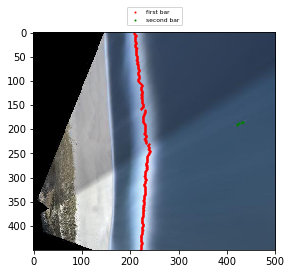

In [5]:
%%time
start_row = 200
end_row = 650
img = plt.imread(os.path.join(img_path,imgs[14]))[start_row:end_row,:,:]
# Feature_STATS = find_feature_column_index(img, threshold_land_water=None, threshold_veg_land=-5)
BAR_STATS = find_bar_only(img, Shoreline_Index=178)

fig,ax = plt.subplots()
ax.imshow(img)
ax.plot(BAR_STATS.First_Bar_IX, BAR_STATS.Row, 'r.', ms=2, label='first bar')
ax.plot(BAR_STATS.Second_Bar_IX, BAR_STATS.Row, 'g.', ms=2, label='second bar')
# ax.plot(Feature_STATS.Shoreline_IX, Feature_STATS.Row, 'b.', ms=2, label='shoreline')
# ax.plot(Feature_STATS.Sand_Vegetation_IX, Feature_STATS.Row, 'g.', ms=2, label='sand-vegetation line')
lg = ax.legend(fontsize=6, loc='upper center', bbox_to_anchor=(0.5, 1.13))

Put locations in arrays, remove rows with NaNs, concatenate.  
TODO: Maybe return array from bar-finding routine, rather than Pandas df.

### Experiment with cluster analysis  
Good info here: https://scikit-learn.org/stable/modules/clustering.html

In [7]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

clust = OPTICS(min_samples=15, xi=.05, min_cluster_size=.05)

bar1 = BAR_STATS[['Row','First_Bar_IX']].to_numpy()
bar1=bar1[~np.isnan(bar1).any(axis=1)].copy()
bar2 = BAR_STATS[['Row','Second_Bar_IX']].to_numpy()
bar2=bar2[~np.isnan(bar2).any(axis=1)].copy()
bar = np.concatenate((bar1,bar2))
bar[:,0]= bar[:,0]+start_row
X = bar

# Run the fit
clust.fit(X)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=20.)
print('Labels: ',np.unique(labels_050))

labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=50.)
print('Labels: ',np.unique(labels_200))

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

# investigate size of labelled classes
label_nums = np.unique(labels)
print('Labels: ',label_nums)
nlabels = len(label_nums)
label_size = np.zeros((nlabels)).astype(int)
for i,label_num in enumerate(label_nums):
    label_size[i]= len(labels[labels==label_num])
    print(i,label_num,label_size[i])
print('Biggest class: ',label_nums[np.argmax(label_size)],' has ',label_size[np.argmax(label_size)])

Labels:  [-1  0]
Labels:  [-1  0]
Labels:  [-1  0  1]
0 -1 241
1 0 154
2 1 63
Biggest class:  -1  has  241


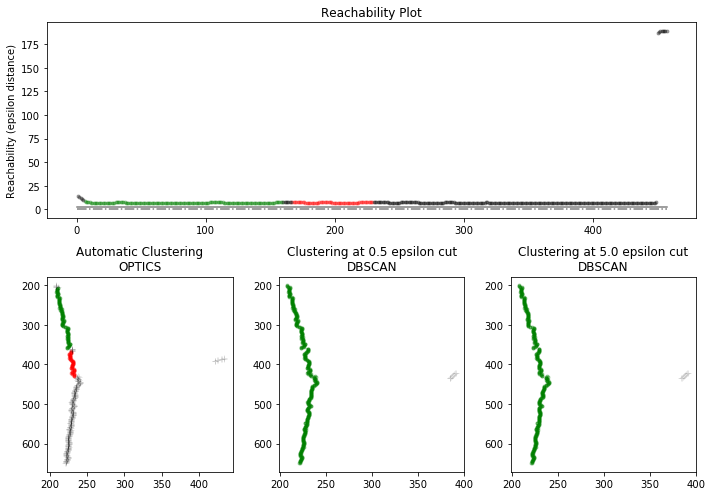

In [8]:
      plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 1], Xk[:, 0], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 1], X[clust.labels_ == -1, 0], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')
ax2.invert_yaxis()

# DBSCAN at 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 1], Xk[:, 0], color, alpha=0.3, marker='.')
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 0.5 epsilon cut\nDBSCAN')
ax3.invert_yaxis()

# DBSCAN at 5.
colors = ['g.', 'm.', 'y.', 'c.']
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 1], Xk[:, 0], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at 5.0 epsilon cut\nDBSCAN')
ax4.invert_yaxis()

plt.tight_layout()
plt.show()

Test All Images

No data: 1594319401.jpg
Wall time: 53.4 s


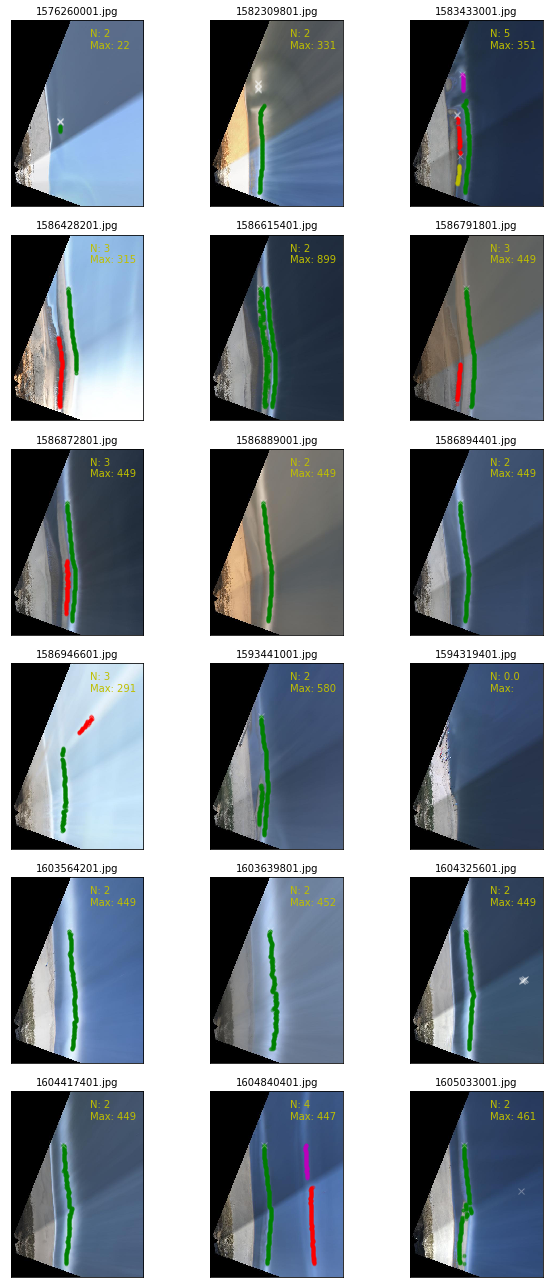

In [9]:
%%time
from sklearn.cluster import OPTICS, cluster_optics_dbscan
clust = OPTICS(min_samples=15, xi=.05, min_cluster_size=.05)

anis_fac = 0.25
eps = 20.

colors = ['g.', 'r.','m.', 'y.', 'c.']
start_row = 200
end_row = 650
ncols = 3
nrows = np.ceil(np.size(imgs)/3.).astype(int)
figy = 3*nrows
fig1,ax = plt.subplots(figsize=(9,figy),ncols=ncols, nrows=nrows)

ax=ax.flatten()
for ic,im in enumerate(imgs):

    img = plt.imread(os.path.join(img_path,im))

    BAR_STATS = find_bar_only(img[start_row:end_row,:,:], Shoreline_Index=178)
    
    # put output into 2D array, remove NaNs, correct row offset
    bar1 = BAR_STATS[['Row','First_Bar_IX']].to_numpy()
    bar1=bar1[~np.isnan(bar1).any(axis=1)].copy()
    bar2 = BAR_STATS[['Row','Second_Bar_IX']].to_numpy()
    bar2=bar2[~np.isnan(bar2).any(axis=1)].copy()
    bar = np.concatenate((bar1,bar2))
    bar[:,0]= bar[:,0]+start_row

    ax[ic].imshow(img)

    if(bar.size>0):

        # scale for anisotropy
        barscl = bar.copy()
        barscl[0,:]=barscl[0,:]*anis_fac
    
        # Run the fit
        clust.fit(barscl)
 
        labels = cluster_optics_dbscan(reachability=clust.reachability_,
                                           core_distances=clust.core_distances_,
                                           ordering=clust.ordering_, eps=eps)
    
        sorted_labels, sorted_size = sort_labels(labels)

        for i in np.arange(min(5,len(sorted_labels))):
            bc = bar[labels == sorted_labels[i],:]
            if(sorted_labels[i]==-1):
                color = 'wx'
            else:
                color = colors[i]
            ax[ic].plot(bc[:, 1], bc[:, 0], color, alpha=0.3)
            
        ts = 'N: {}\nMax: {:.0f}'.format(len(sorted_labels),sorted_size[0])
        ax[ic].text(.6,.85,ts,transform = ax[ic].transAxes,color='y')

    else:
        print('No data:',im)
        ts = 'N: {}\nMax: {}'.format(0.,'')
        ax[ic].text(.6,.85,ts,transform = ax[ic].transAxes,color='y')
        
    ax[ic].set_xlim([0,500])
    ax[ic].set_xticklabels('')
    ax[ic].set_yticklabels('')
    ax[ic].set_xticks([])
    ax[ic].set_yticks([])
    ax[ic].set_title(im, fontsize=10)
        
fig1.tight_layout()
plt.savefig('testcases.png',dpi=200)